## Import Libraries

In [1]:
!pip install nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import csr_matrix
from nltk.tokenize import word_tokenize
from collections import Counter, OrderedDict
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
pd.options.display.max_colwidth=500

## Load Data

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)

val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)

test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [5]:
# Inspect
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
14008,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
14009,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
14010,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
14011,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


## Helper Functions

In [6]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [7]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [8]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

## Create Character Document

In [9]:
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    Improve this for Q3

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        #remove the empty lines
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

* print out the number of words each character has in the training set
* only use the first 300 lines of each character

In [10]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)

lines per character {'SHIRLEY': 300, 'OTHER': 300, 'JACK': 300, 'RONNIE': 300, 'TANYA': 300, 'SEAN': 300, 'ROXY': 300, 'MAX': 300, 'IAN': 300, 'JANE': 300, 'STACEY': 300, 'PHIL': 300, 'HEATHER': 300, 'MINTY': 300, 'CHRISTIAN': 300, 'CLARE': 300}


In [11]:
print('Num. Characters: ',len(train_character_docs.keys()),"\n")

total_words = 0

for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())

print("total words", total_words)

Num. Characters:  16 

SHIRLEY Number of Words:  3100
OTHER Number of Words:  2673
JACK Number of Words:  3707
RONNIE Number of Words:  3005
TANYA Number of Words:  3291
SEAN Number of Words:  2868
ROXY Number of Words:  3119
MAX Number of Words:  3884
IAN Number of Words:  3467
JANE Number of Words:  3128
STACEY Number of Words:  3235
PHIL Number of Words:  3129
HEATHER Number of Words:  3262
MINTY Number of Words:  3310
CHRISTIAN Number of Words:  3278
CLARE Number of Words:  3623
total words 52079


## Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 50 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially, the code in this template achieves a mean rank of **4.3**  and accuracy of **0.25** on the test set and a mean rank of **3.6** and accuracy of **0.31** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [12]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    ::character_text:: a string with all of one character's lines
    """
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    character_text = re.sub("[^a-zA-Z]", " ", character_text) # 1. remove punctuation
    tokens = nltk.word_tokenize(character_text) # 2. transform text into tokens
    lower_case = [l.lower() for l in tokens] # 3. normalize by lower casing
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # 4. remove stop words
    stems = [stemmer.stem(t) for t in filtered_result] # 5. apply stemming
    return stems

In [13]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [14]:
print(training_corpus[0])

('CHRISTIAN', ['lesley', 'realli', 'glad', 'must', 'ian', 'eol', 'partner', 'ashley', 'eol', 'love', 'littl', 'place', 'eol', 'seen', 'flesh', 'ashley', 'lesley', 'compar', 'way', 'describ', 'eol', 'keep', 'forget', 'lesley', 'chang', 'name', 'would', 'therapist', 'bloke', 'make', 'eol', 'might', 'say', 'indic', 'attempt', 'run', 'away', 'someth', 'let', 'go', 'eol', 'amongst', 'thing', 'eol', 'sister', 'call', 'love', 'hate', 'relationship', 'love', 'hate', 'right', 'jane', 'love', 'much', 'break', 'heart', 'eol', 'bottl', 'best', 'champagn', 'pleas', 'start', 'count', 'penni', 'jane', 'pay', 'ash', 'eol', 'know', 'ian', 'exactli', 'imagin', 'say', 'ash', 'kind', 'bloke', 'jane', 'would', 'end', 'marri', 'mean', 'david', 'alway', 'go', 'tough', 'act', 'follow', 'word', 'think', 'found', 'eol', 'yeah', 'well', 'eol', 'ash', 'hampstead', 'heath', 'eol', 'realli', 'allow', 'say', 'eol', 'well', 'author', 'take', 'dim', 'view', 'probat', 'offic', 'date', 'client', 'eol', 'well', 'certainl

### Test the new Preprocessing approach
using the initial feature vectorizer and matrix transformation functions

In [15]:
corpusVectorizer = DictVectorizer()

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    return doc_feature_matrix

In [16]:
# Get the validation data
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}


In [17]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # Just transform the val_feature_matrix, don't fit

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.0
mean cosine similarity 0.9458177520689279
12 correct out of 16 / accuracy: 0.75


## Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions below. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like [k-best](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) selection using different statistical tests.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

### Feature Extraction

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Enhanced with n-grams, POS tags, and VADER sentiment analysis.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    # 1. Simple token counts (unigrams)
    counts = Counter(character_doc)

    # 2. Generate bigrams and trigrams
    for n in range(1, 3):
        ngram_list = ["_".join(gram) for gram in nltk.ngrams(character_doc, n)]
        counts.update(Counter(ngram_list))

    # 3. Add POS tags
    pos_tags = nltk.pos_tag(character_doc)
    pos_counts = Counter(tag for word, tag in pos_tags)
    counts.update(pos_counts)

    # 4. Add Sentiment Analysis features
    text = " ".join(character_doc)
    sentiment_scores = sia.polarity_scores(text)
    counts["sentiment_pos"] = sentiment_scores["pos"]
    counts["sentiment_neg"] = sentiment_scores["neg"]
    counts["sentiment_neu"] = sentiment_scores["neu"]
    counts["sentiment_compound"] = sentiment_scores["compound"]

    # Add extra features
    for feature in extra_features:
        counts[feature] += 1

    return dict(counts)

### Matrix Transformation

In [19]:
matrix_transformer_config = {
    "max_features": 100,
    "use_tfidf": True
}

In [20]:
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()
feature_selector = None

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Enhanced with TF-IDF transformation and optional feature selection.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data).
    ::max_features:: max number of features to retain (used for feature selection).
    ::use_tfidf:: whether to apply TF-IDF transformation.
    """
    global feature_selector

    if matrix_transformer_config:
      max_features, use_tfidf = matrix_transformer_config.values()
    else:
      max_features, use_tfidf = None, False

    # Convert documents to feature dictionaries
    feature_dicts = [to_feature_vector_dictionary(doc, []) for _, doc in corpus]

    if fitting:
        # Fit vectorizer
        corpusVectorizer.fit(feature_dicts)

        # Transform the data
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            tfidf_transformer.fit(feature_matrix)
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if max_features is set
        if max_features is not None:
            feature_selector = SelectKBest(chi2, k=max_features)
            feature_selector.fit(feature_matrix, [label for label, _ in corpus])
            feature_matrix = feature_selector.transform(feature_matrix)
    else:
        # Transform the data without fitting
        feature_matrix = corpusVectorizer.transform(feature_dicts)

        # Apply TF-IDF if enabled
        if use_tfidf:
            feature_matrix = tfidf_transformer.transform(feature_matrix)

        # Apply feature selection if it was previously fitted
        if feature_selector is not None:
            feature_matrix = feature_selector.transform(feature_matrix)

    return feature_matrix

## Evaluate the new techniques

In [21]:
# Get the validation data- only 50 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=50)
print('Num of Characters: ',len(val_character_docs.keys()),"\n")

total_words = 0

for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())

print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'OTHER': 50, 'HEATHER': 43, 'TANYA': 50, 'JACK': 50, 'RONNIE': 40, 'JANE': 50, 'STACEY': 50, 'SEAN': 50, 'PHIL': 32, 'SHIRLEY': 50, 'ROXY': 30, 'IAN': 50, 'MINTY': 50, 'CHRISTIAN': 30, 'CLARE': 28, 'MAX': 50}
Num of Characters:  16 

OTHER Num of Words:  463
HEATHER Num of Words:  514
TANYA Num of Words:  487
JACK Num of Words:  491
RONNIE Num of Words:  376
JANE Num of Words:  596
STACEY Num of Words:  508
SEAN Num of Words:  513
PHIL Num of Words:  366
SHIRLEY Num of Words:  583
ROXY Num of Words:  327
IAN Num of Words:  662
MINTY Num of Words:  603
CHRISTIAN Num of Words:  347
CLARE Num of Words:  449
MAX Num of Words:  565
total words 7850


In [22]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.4375
mean cosine similarity 0.5703856388520637
14 correct out of 16 / accuracy: 0.875


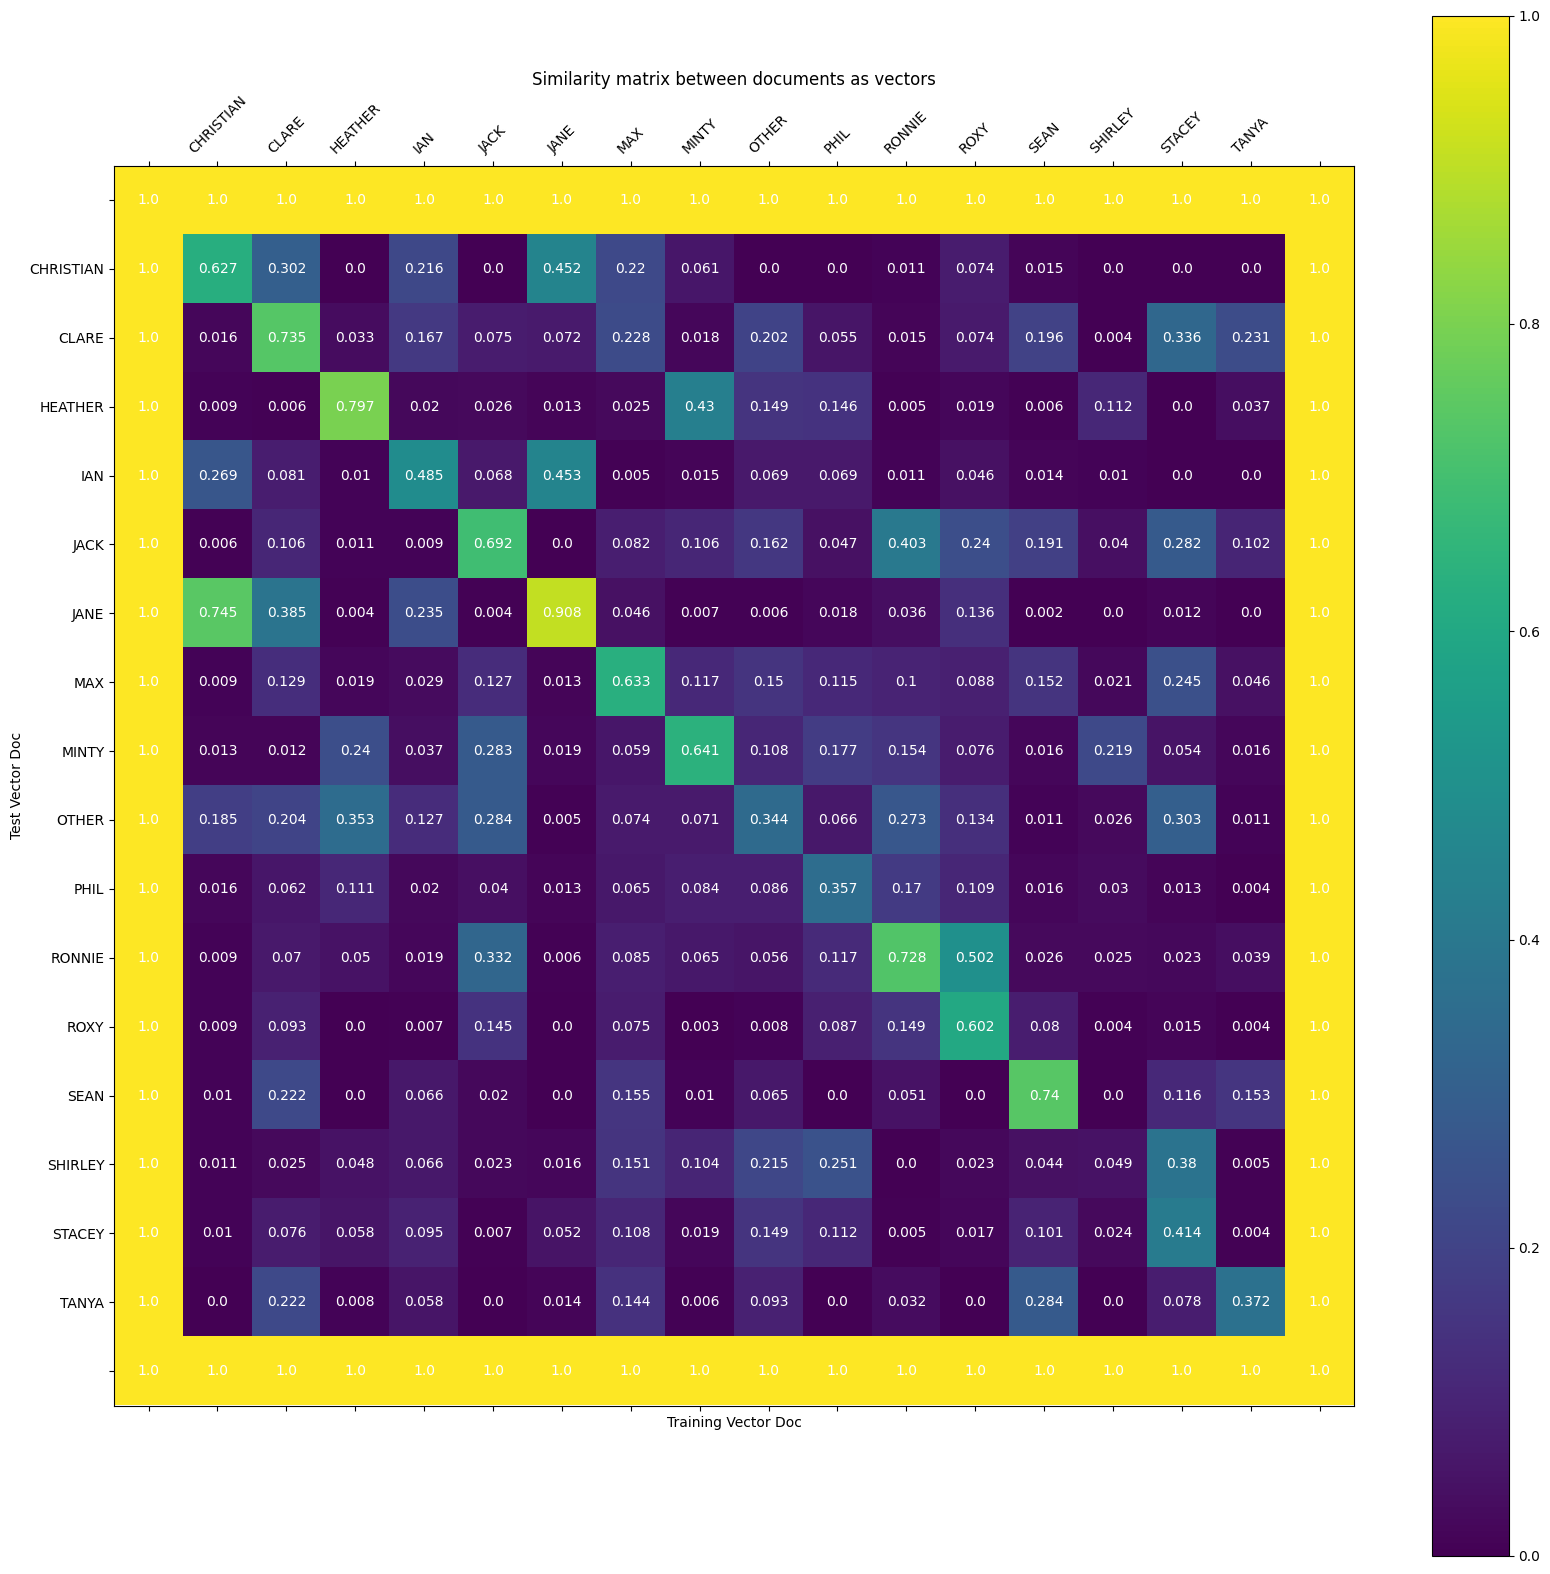

In [23]:
plot_heat_map_similarity(df)